using Revise

```julia
import Pkg; 
Pkg.add("HTTP")
Pkg.add("JSON")
Pkg.add("JLD")
Pkg.add("FreqTables")
Pkg.update("DataStructures")
```

In [ ]:
import Pkg; 
Pkg.add("Distances")
using Distances
Pkg.add("LightGraphs")
Pkg.add("SimpleWeightedGraphs")
Pkg.add("GraphIO")
Pkg.add("ParserCombinator")
using SimpleWeightedGraphs, GraphIO, ParserCombinator

In [ ]:
Pkg.update("CSV")

In [ ]:
import Pkg; 
Pkg.add("HTTP")
Pkg.add("JSON")
Pkg.add("JLD")
Pkg.add("FreqTables")
Pkg.update("DataStructures")
Pkg.add(Pkg.PackageSpec(url = "https://github.com/menchelab/RMP.jl.git"))

```julia
    import Pkg
    Pkg.add(Pkg.PackageSpec(url = "https://github.com/menchelab/RMP.jl.git"))
    using RMP
```

In [ ]:
Pkg.add("FreqTables")

In [1]:
using CSV, StatsBase, Statistics, DataFrames, UMAP, RCall, FreqTables
using MultipleTesting, Random, MultivariateStats, Distributed
using HTTP, JSON
using RMP

┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1260
┌ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1260
┌ Info: Precompiling RCall [6f49c342-dc21-5d91-9882-a32aef131414]
└ @ Base loading.jl:1260
┌ Info: Precompiling FreqTables [da1fdf0e-e0ff-5433-a45f-9bb5ff651cb1]
└ @ Base loading.jl:1260
┌ Info: Precompiling HTTP [cd3eb016-35fb-5094-929b-558a96fad6f3]
└ @ Base loading.jl:1260
┌ Info: Precompiling RMP [cef322dc-4d82-11ea-04a7-113231db804d]
└ @ Base loading.jl:1260


In [2]:
using Dates: now
now()

2020-12-29T17:19:44.389

## R Calls

In [3]:
@rlibrary ggplot2
@rlibrary extrafont
@rlibrary viridis
@rlibrary heatmaply
@rlibrary ggrepel

In [4]:
R"""
# Used later for MCD computation

library(robustbase)

# Customize ggplot appearance

library(ggplot2)
library(extrafont)


# Load extra fonts
ttf_import("/tmp/.fonts")
loadfonts()

# Change theme
customTheme <- theme_light() + 
               theme(panel.grid.minor=element_blank(), text=element_text(size=17, family="Arial", colour = "#333333"),
                     line=element_line(colour = "#333333"), 
                     legend.background = element_rect(fill=alpha('#CCCCCC', 0.1)), legend.key = element_blank())

# Change default colors
scale_colour_continuous <- function (..., begin = 0.1, end = 0.9, direction = -1, option = "plasma", 
                                     type = getOption("ggplot2.continuous.colour", default = "viridis")) {
    switch(type, gradient = scale_colour_gradient(...), 
        viridis = scale_colour_viridis_c(option = option, begin = begin, end = end, direction = direction, ...), 
        stop("Unknown scale type", call. = FALSE))
}
scale_color_continuous <- scale_colour_continuous

scale_fill_continuous <- function (..., begin = 0.1, end = 0.9, direction = -1, option = "plasma", 
                                     type = getOption("ggplot2.continuous.colour", default = "viridis")) {
    switch(type, gradient = scale_fill_gradient(...), 
        viridis = scale_fill_viridis_c(option = option, begin = begin, end = end, direction = direction, ...), 
        stop("Unknown scale type", call. = FALSE))

}

cemm_pal = colorRampPalette(c("#5A463C", "#008CAD", "#40B9D4", "#D4ECF2", "#D2323C", "#F8B100", "#DFDC00"))
scale_fill_discrete <- function (..., type = "CeMM", h = c(0, 360) + 15, c = 100, l = 65, h.start = 0, 
    direction = 1, na.value = "grey50", aesthetics = "fill") 
{
    if (type == "CeMM"){
        discrete_scale(aesthetics, "CeMM", cemm_pal, na.value = na.value, ...)
    } else {
        discrete_scale(aesthetics, "hue", hue_pal(h, c, l, h.start, 
            direction), na.value = na.value, ...)
    }
}

scale_color_discrete <- function (..., type = "CeMM", h = c(0, 360) + 15, c = 100, l = 65, h.start = 0, 
    direction = 1, na.value = "grey50", aesthetics = "colour") {
    if (type == "CeMM"){
        discrete_scale(aesthetics, "CeMM", cemm_pal, na.value = na.value, ...)
    } else {
        discrete_scale(aesthetics, "hue", scales::hue_pal(h, c, l, h.start, 
            direction), na.value = na.value, ...)
    }
}
scale_colour_discrete <- scale_color_discrete

noGridTheme <- function(...){
    theme(panel.grid.major=element_blank(), axis.text.x=element_text(size=12), axis.text.y=element_text(size=12),
                      axis.line=element_line(color="#333333", size = 0.2), panel.border = element_blank(), ...)
}

darkTheme <- function(...){
    theme(panel.background = element_rect(fill = '#333333'), plot.background = element_rect(fill = '#333333'), 
          axis.line=element_line(color="#CCCCCC", size = 0.2), 
          text=element_text(size=17, family="Arial", colour = "#CCCCCC"),
          line=element_line(colour = "#CCCCCC"))
}

theme_set(customTheme)

options(repr.plot.width=10, repr.plot.height=10)
"""

┌ Warning: RCall.jl: Registering fonts with R
└ @ RCall /opt/julia/packages/RCall/eRsxl/src/io.jl:160
┌ Warning: RCall.jl: Scanning ttf files in /tmp/.fonts ...
│ Extracting .afm files from .ttf files...
│ /tmp/.fonts/Arial.ttf : ArialMT already registered in fonts database. Skipping.
│ Found FontName for 0 fonts.
│ Scanning afm files in /opt/conda/lib/R/library/extrafontdb/metrics
│ Warning in grepl("^FamilyName", text) :
│   input string 4 is invalid in this locale
│ Warning in grepl("^FontName", text) :
│   input string 4 is invalid in this locale
│ Warning in grepl("^FullName", text) :
│   input string 4 is invalid in this locale
│ Warning in grepl("^Weight", text) :
│   input string 4 is invalid in this locale
└ @ RCall /opt/julia/packages/RCall/eRsxl/src/io.jl:160
┌ Warning: RCall.jl: Arial already registered with pdfFonts().
└ @ RCall /opt/julia/packages/RCall/eRsxl/src/io.jl:160


RObject{VecSxp}
$repr.plot.width
NULL

$repr.plot.height
NULL



## Load pre-computed statistical distances to DMSO

In [16]:
RMPV = CSV.read("data/DrugScreen/RMPV.csv", DataFrame) 

,RawPVal,RMPV,RHD,Condition
,Float64,Float64,Float64,String
1,0.2702,0.355804,0.133976,(+)-Butaclamol hydrochloride
2,0.8128,0.826911,0.0399052,(+)-Cyclazocine
3,0.2826,0.364766,0.149507,(+/-)-Sulfinpyrazone
4,0.0788,0.13993,0.245043,(-)-JQ1
5,0.0004,0.00124681,0.542844,(-)-Perillic acid
6,0.1192,0.188087,0.222888,(-)-Quinpirole hydrochloride
7,0.1194,0.188087,0.257347,"(-)-trans-(1S,2S)-U-50488 hydrochloride"
8,0.0,0.0,0.999016,(S)-(+)-Camptothecin
9,0.341,0.418046,0.122715,(S)-Propranolol hydrochloride


In [17]:
RMPV.Condition[RMPV.RMPV .< 0.05]

126-element Array{String,1}:
 "(-)-Perillic acid"
 "(S)-(+)-Camptothecin"
 "(±)-Octoclothepin maleate"
 "(±)-SKF-38393 hydrochloride"
 "2-methoxyestradiol"
 "5-(N,N-hexamethylene)amiloride"
 "5-(N-Ethyl-N-isopropyl)amiloride"
 "5-Fluorouracil"
 "5-azacytidine"
 "6-Nitroso-1,2-benzopyrone"
 "7-Cyclopentyl-5-(4-phenoxy)phenyl-7H-pyrrolo[2,3-d]pyrimidin-4-ylamine"
 "AEG 3482"
 "AZ191"
 ⋮
 "Thiocolchicine"
 "Tizanidine hydrochloride"
 "Trifluperidol hydrochloride"
 "Triflupromazine hydrochloride"
 "Trilostane"
 "Tyrphostin AG 879"
 "U0126"
 "Vorinostat"
 "WZ4003"
 "Wiskostatin"
 "XL388"
 "beta-Lapachone"

## Get annotations

In [7]:
salt_to_remove = [" maleate", " hydrochloride", " nitrate", 
                  " dihydrochloride", " chloride", " sulfate", 
                  " hydrate", " mesylate", " oxalate", " salt",
                  " from Penicillium brefeldianum", " monohydrate",
                  " trifluoroacetate", " acetate", " isethionate",
                  " hemisulfate", " angular", " sodium", " fumarate",
                  " methanesulfonate", " hemihydrate", " (MW = 374.83)"]

"""Other compounds might include salts but are anyway not found in the LINCS database at all:
    AC-93253 iodide
    N-p-Tosyl-L-phenylalanine chloromethyl ketone
    4-(2-Aminoethyl)benzenesulfonyl fluoride hydrochloride
    UNC0379 trifluoroacetate salt"""

salt_dict = Dict(s => s"" for s in salt_to_remove)
salt_dict[" "] = s"-";

In [8]:
"""
This function parse a list of compound canonical IDs and extract mechanism of actions (MOA)
annotated in the LINCS perturbation database when provided. Returns a list of annotates MOAs
See https://clue.io/developer-resources#apisection
"""
function getMOA(cpd::String)
    user_key = "3a73a242e38f9fb6375a1100354e4107"
    rootURL = "https://api.clue.io/api/perts?filter={\"where\":{\"pert_iname\":\""
    typeURL = "\"},\"fields\":{\"moa\":true}}&user_key="
    # NB: case-dependent. Dashes are handled. Spaces are usually replaced by dashes.
    
    cpd_no_salt = reduce(replace, salt_dict, init=cpd)
    
    rq = rootURL * lowercase(cpd_no_salt) * typeURL * user_key
    
    try
        resRq = HTTP.get(rq)
        moaRQ = JSON.Parser.parse(String(resRq.body))[1]
        return(moaRQ["moa"])
    catch e
        if isa(e, BoundsError)
            rq = rootURL * uppercase(cpd_no_salt) * typeURL * user_key
            try
                resRq = HTTP.get(rq)
                moaRQ = JSON.Parser.parse(String(resRq.body))[1]
                return(moaRQ["moa"])
            catch e
                if isa(e, BoundsError)
                println(cpd*" does not have an MOA annotation.")
                end
            end
        elseif isa(e, HTTP.ExceptionRequest.StatusError)
            println(cpd*" raises a 502 error.")
        end
        return()
    end
end

getMOA

In [ ]:
MOA = Dict()
for cpd in RMPV.Condition
    moa = getMOA(cpd)
    if length(moa) > 0
        MOA[cpd] = moa
    end
end

In [ ]:
cpd_list = Set(RMPV.Condition)
map(x -> pop!(cpd_list, x), collect(keys(MOA)));

In [ ]:
for cpd in cpd_list
    moa = getMOA(cpd)
    if length(moa) > 0
        MOA[cpd] = moa
    end
end

In [ ]:
length(MOA)

In [ ]:
MOA

You can save the MOA dictionary for later use:
```julia
using HDF5, JLD
save("Data/MOA.jld", "data", MOA)
MOA = load("Data/MOA.jld")["data"]
```

In [10]:
freqMOA = sort(freqtable(vcat(collect(values(MOA))...)), rev = true);

In [18]:
hitMOA = Dict(x => MOA[x] for x in RMPV.Condition[RMPV.RMPV .< 0.1] if x in keys(MOA))
freqHitMOA = sort(freqtable(vcat(collect(values(hitMOA))...)), rev = true);

In [19]:
dfMOA = DataFrame()
dfMOA.MOA = repeat(names(freqMOA)[1][freqMOA .> 3], 2)
dfMOA.Hits = repeat([true, false], inner = Int(length(dfMOA.MOA)/2))
dfMOA.Count = zeros(length(dfMOA.MOA));

In [20]:
for row in eachrow(dfMOA)
    if row.Hits
        if row.MOA in names(freqHitMOA)[1]
            row.Count = Dict(freqHitMOA)[row.MOA]
        end
    else
        if row.MOA in names(freqHitMOA)[1]
            row.Count = Dict(freqMOA)[row.MOA] - Dict(freqHitMOA)[row.MOA]
        else
            row.Count = Dict(freqMOA)[row.MOA]
        end
        
        
    end
end
dfMOA.MOA = CategoricalArray{String,1}(dfMOA.MOA, levels = reverse(names(freqMOA)[1][freqMOA .> 3]), ordered=true);

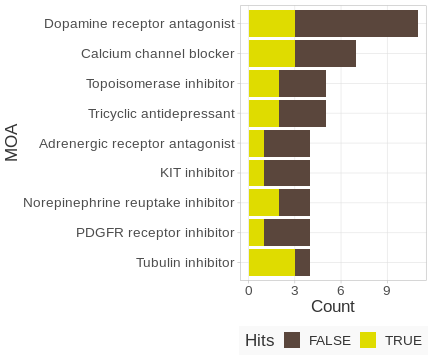

RObject{VecSxp}


In [21]:
gp = ggplot(dfMOA, aes(x = :MOA, y = :Count, fill = :Hits)) + 
     geom_bar(position="stack", stat="identity") + coord_flip() + 
     theme(var"legend.position"="bottom")

In [ ]:
ggsave("Fig/HitEnrichment.pdf", gp)

## UMAP of top MOAs

In [22]:
cpdTopMOA = Set([k for (k,v) in MOA for m in v if m in names(freqMOA)[1][freqMOA .> 3]])

Set{String} with 41 elements:
  "Pimozide"
  "Amsacrine hydrochloride"
  "Droperidol"
  "Mitoxantrone"
  "Irinotecan"
  "Protriptyline hydrochloride"
  "Nicardipine hydrochloride"
  "Acepromazine maleate"
  "Albendazole"
  "Maprotiline hydrochloride"
  "Pazopanib"
  "Imatinib mesylate"
  "Imipramine hydrochloride"
  "Trimipramine maleate"
  "Levetiracetam"
  "Nocodazole"
  "Ellipticine"
  "Flunarizine dihydrochloride"
  "Doxazosin mesylate"
  "Podophyllotoxin"
  "Maprotiline"
  "Promazine hydrochloride"
  "Sunitinib"
  "Dantrolene sodium"
  "Domperidone"
  ⋮ 

.
```
["Serotonin receptor antagonist"
"Serotonin reuptake inhibitor"
"Tubulin inhibitor"
```


```
@0.05 FDR
Norepinephrine reuptake inhibitor
Tubulin inhibitor
Calcium channel blocker
```


```
@0.1 FDR
Tubulin inhibitor
Dopamine receptor antagonist
Calcium channel blocker
```

Is there overlap in drugs? Overlap in morphological space? Map of the 9 Compounds.

In [25]:
freqHitMOA

49-element Named Array{Int64,1}
Dim1                                              │ 
──────────────────────────────────────────────────┼──
Calcium channel blocker                           │ 3
Dopamine receptor antagonist                      │ 3
Tubulin inhibitor                                 │ 3
CDK inhibitor                                     │ 2
Glycogen synthase kinase inhibitor                │ 2
Norepinephrine reuptake inhibitor                 │ 2
Opioid receptor agonist                           │ 2
Ribonucleotide reductase inhibitor                │ 2
Selective serotonin reuptake inhibitor (SSRI)     │ 2
Topoisomerase inhibitor                           │ 2
Tricyclic antidepressant                          │ 2
ATPase inhibitor                                  │ 1
⋮                                                   ⋮
Phosphodiesterase inhibitor                       │ 1
Potassium channel antagonist                      │ 1
Protein synthesis inhibitor                       │

### Load aggregated data

In [77]:
aggregatedData = CSV.read("data/aggregatedData_750cells.csv", DataFrame);

### Transform aggregated data - Normalization
We want to focus on variables that are changing more overall than inside of reference condition (untreated WT).

In [78]:
expAgg = Experiment(aggregatedData, description = "Median values for aggregated FOV measurements")

"Experiment with 6444/6444 entries and 390/390 features selected."

In [79]:
filters = Array{RMP.AbstractSelector,1}()
# Remove metadata
strToRemove = ["Metadata_Well", "CompoundName", "Metadata_Field", "Metadata_Row", "Metadata_Column"]
push!(filters, NameSelector(x -> !any(occursin.(strToRemove, String(x)))))
# Remove constant columns
push!(filters, Selector(x -> mad(x, normalize = true) != 0, description = "Remove constant features"));
push!(filters, Selector(x -> mad(x, normalize = true) != 0, 
                        subset = x -> x.CompoundName .== "DMSO", 
                        description = "Remove features constant for reference"))
selectFeaturesExperiment!(expAgg, filters)

In [80]:
expTransformed = deepcopy(expAgg)
logtransform!(expTransformed)
expTransformed.description = "Transformed values for aggregated FOV measurements"

"Transformed values for aggregated FOV measurements"

Here we apply a correction based on the specific details of the experimental design:
All rows and columns include DMSO (negative) controls and we normalize all values based on these matchings controls (same row and column).  

This examplifies how to directly modify the data of an `Experiment` object.  

NB: One might want to check that more iterations are not needed (cf. Median-polish method).

In [81]:
# Normalize on matching DMSO wells median values

# Entries in both data frames are matching
@assert nrow(aggregatedData) == nrow(getdata(expTransformed))

# Copy data before correction
ndf = getdata(expTransformed)

for (i, (fx, fy)) in enumerate(eachrow(aggregatedData[:,[:Metadata_Row, :Metadata_Column]])) 
    c1 = aggregatedData.CompoundName .== "DMSO"
    c2 = aggregatedData.Metadata_Row .== fx
    c3 = aggregatedData.Metadata_Column .== fy
    @assert sum((c1 .& (c2 .| c3))) > 0
    expTransformed.data[i:i, expTransformed.selectedFeatures] .-= 
        mapcols(median, ndf[(c1 .& (c2 .| c3)),:]) 
end

In [82]:
compare_in(x,y) = x in y
Broadcast.broadcasted(::typeof(compare_in), x, y) = broadcast(in, x, Ref(y)) 
# We now only keep compounds having one of the most common MOA
filterEntriesExperiment!(expTransformed, Filter(cpdTopMOA, :CompoundName, compare = compare_in));

## Visualization

In [86]:
Random.seed!(3895)
umTPM = umap(expTransformed)
umTPM = convert(DataFrame, umTPM')
names!(umTPM, [:UMAP1, :UMAP2]);
umTPM.Compound = expTransformed.data.CompoundName[expTransformed.selectedEntries]
umTPM.MOA = CategoricalArray([MOA[x] for x in umTPM.Compound]);

┌ Warning: `names!(df::AbstractDataFrame, vals::Vector{Symbol}; makeunique::Bool = false)` is deprecated, use `rename!(df, vals, makeunique = makeunique)` instead.
│   caller = top-level scope at In[86]:4
└ @ Core In[86]:4


In [87]:
umTPM

,UMAP1,UMAP2,Compound,MOA
,Float64,Float64,String,Cat…
1,-1.86325,0.599231,Acepromazine maleate,"Any[""Dopamine receptor antagonist""]"
2,0.974221,0.767866,Trimipramine maleate,"Any[""Norepinephrine reuptake inhibitor"", ""Tricyclic antidepressant""]"
3,-3.68234,-2.75174,Pazopanib,"Any[""KIT inhibitor"", ""PDGFR receptor inhibitor"", ""VEGFR inhibitor""]"
4,-3.57406,-2.86182,Protriptyline hydrochloride,"Any[""Tricyclic antidepressant""]"
5,-2.32456,-2.74235,Chlorpromazine hydrochloride,"Any[""Dopamine receptor antagonist""]"
6,-1.10051,-2.16933,Pimozide,"Any[""Dopamine receptor antagonist""]"
7,-0.711413,-2.50244,Dantrolene sodium,"Any[""Calcium channel blocker""]"
8,-1.2969,0.519123,Cilnidipine,"Any[""Calcium channel blocker""]"
9,-0.927242,-0.812589,Nicardipine hydrochloride,"Any[""Calcium channel blocker""]"


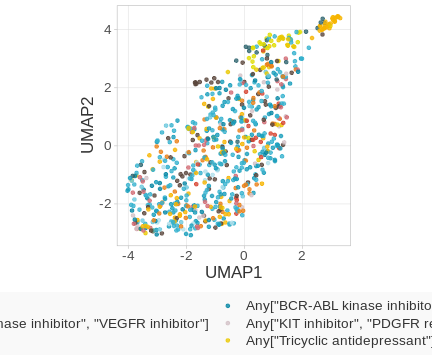

RObject{VecSxp}


In [88]:
ggplot(umTPM, aes(:UMAP1, :UMAP2)) + 
    geom_point(aes(color = :MOA), alpha = 0.8) +
    coord_fixed() + 
    theme(var"legend.position"="bottom", var"legend.spacing.x" = unit(0.35, "cm"), 
    var"legend.spacing.y" = unit(0, "cm")) + 
    guides(color=guide_legend(nrow=3,byrow=true))

NB: Morphological distance between MOA?
Start with 2 MOAs that could be similar and 2 that should be distinct.

In [ ]:
"Serotonin receptor antagonist"
"Serotonin reuptake inhibitor"
"Tubulin inhibitor"

## MOA similarity network

### Based on median cosine similarity at the image-level.

In [101]:
# We focus on MOAs with at least 2 compounds
selected_moa = names(freqHitMOA)[1][freqHitMOA .>= 2]
selected_cpd = [k for (k,v) in hitMOA if any([x in v for x in selected_moa])]

23-element Array{String,1}:
 "Loperamide"
 "Roscovitine"
 "Vinblastine"
 "Nortriptyline hydrochloride"
 "Maprotiline hydrochloride"
 "SB 415286"
 "Nocodazole"
 "Kenpaullone"
 "Domperidone"
 "Triflupromazine hydrochloride"
 "Fluoxetine hydrochloride"
 "Gemcitabine hydrochloride"
 "Nisoldipine"
 "Irinotecan"
 "Albendazole"
 "Imipramine hydrochloride"
 "Ellipticine"
 "Flunarizine dihydrochloride"
 "Paroxetine hydrochloride hemihydrate (MW = 374.83)"
 "Pimozide"
 "Cytarabine"
 "Cilnidipine"
 "Loperamide hydrochloride"

In [102]:
expTransformed = deepcopy(expAgg)
logtransform!(expTransformed)
expTransformed.description = "Transformed values for aggregated FOV measurements"

"Transformed values for aggregated FOV measurements"

Here we apply a correction based on the specific details of the experimental design:
All rows and columns include DMSO (negative) controls and we normalize all values based on these matchings controls (same row and column).  

This examplifies how to directly modify the data of an `Experiment` object.  

NB: One might want to check that more iterations are not needed (cf. Median-polish method).

In [103]:
# Normalize on matching DMSO wells median values

# Entries in both data frames are matching
@assert nrow(aggregatedData) == nrow(getdata(expTransformed))

# Copy data before correction
ndf = getdata(expTransformed)

for (i, (fx, fy)) in enumerate(eachrow(aggregatedData[:,[:Metadata_Row, :Metadata_Column]])) 
    c1 = aggregatedData.CompoundName .== "DMSO"
    c2 = aggregatedData.Metadata_Row .== fx
    c3 = aggregatedData.Metadata_Column .== fy
    @assert sum((c1 .& (c2 .| c3))) > 0
    expTransformed.data[i:i, expTransformed.selectedFeatures] .-= 
        mapcols(median, ndf[(c1 .& (c2 .| c3)),:]) 
end

In [104]:
compare_in(x,y) = x in y
Broadcast.broadcasted(::typeof(compare_in), x, y) = broadcast(in, x, Ref(y)) 
# We now only keep compounds having one of the most common MOA
filterEntriesExperiment!(expTransformed, Filter(selected_cpd, :CompoundName, compare = compare_in));

In [116]:
# Image cosine similarities
imgCosSim = 1 .- pairwise(CosineDist(), Array(getdata(expTransformed))');

In [155]:
# Store MOA cosine similarity
moaCosSim = Dict()
cmp_names = expTransformed.data[expTransformed.selectedEntries, :CompoundName] 
# For all combinations (avoiding duplicates)
for (moa1, moa2) in [(x,y) for (x,y) in Iterators.product(selected_moa, selected_moa) if x >= y]
    # Get compounds and corresponding images for each MOA
    cmp_moa1 = [k for (k,v) in hitMOA if moa1 in v]
    ind_moa1 = findall([x in cmp_moa1 for x in cmp_names])
    cmp_moa2 = [k for (k,v) in hitMOA if moa2 in v]
    ind_moa2 = findall([x in cmp_moa2 for x in cmp_names])
    # Take median value
    moaCosSim[(moa1, moa2)] = median([imgCosSim[x...] for x in Iterators.product(ind_moa1, ind_moa2)])
end

In [159]:
# Display for MOA self-similarity
for moa in selected_moa
    println(moa, ": ", moaCosSim[(moa, moa)])
end

Calcium channel blocker: 0.2729110243281319
Dopamine receptor antagonist: 0.17718574976274848
Tubulin inhibitor: 0.5301019352185802
CDK inhibitor: 0.7942336704452968
Glycogen synthase kinase inhibitor: 0.546640598358231
Norepinephrine reuptake inhibitor: 0.38453363960112874
Opioid receptor agonist: 0.7693112563276429
Ribonucleotide reductase inhibitor: 0.6174389639853555
Selective serotonin reuptake inhibitor (SSRI): 0.5042558830050818
Topoisomerase inhibitor: 0.8693563610498366
Tricyclic antidepressant: 0.5599603707021951


In [199]:
# Get all link with values higher than x
edgesMoaNet = Dict(k => v for (k,v) in moaCosSim if v > 0.35)
println(length(unique([y for x in keys(edgesMoaNet) for y in x ])))
length(edgesMoaNet)

11


50

In [220]:
moaToInt = Dict(x => i for (i, x) in enumerate(selected_moa))
g = SimpleWeightedGraph(11)
# NB: self-edges are kept
[add_edge!(g, moaToInt[k[1]], moaToInt[k[2]], v) for (k,v) in edgesMoaNet];

In [248]:
moaToInt

Dict{String,Int64} with 11 entries:
  "Glycogen synthase kinase inhibitor"            => 5
  "Calcium channel blocker"                       => 1
  "Tubulin inhibitor"                             => 3
  "Tricyclic antidepressant"                      => 11
  "CDK inhibitor"                                 => 4
  "Opioid receptor agonist"                       => 7
  "Topoisomerase inhibitor"                       => 10
  "Dopamine receptor antagonist"                  => 2
  "Selective serotonin reuptake inhibitor (SSRI)" => 9
  "Norepinephrine reuptake inhibitor"             => 6
  "Ribonucleotide reductase inhibitor"            => 8

In [247]:
savegraph("Fig/MOA_similarity_per_image.gml", g, "MOA_similarity", GraphIO.GML.GMLFormat())

1

### Based on cosine similarity of median profile at the MOA-level.

In [258]:
cmp_moas = [MOA[x] for x in cmp_names];

In [270]:
""" For a given `moa`, return the median profile across all
    selected images.
"""
function moaMedProfile(moa::String)
    moa_ind = [moa in cm for cm in cmp_moas]
    return(map(median, eachcol(getdata(expTransformed)[moa_ind,:])))
end

moaMedProfile

In [278]:
moaProf = hcat(map(moaMedProfile, selected_moa)...)
moaCosSim2 = 1 .- pairwise(CosineDist(), moaProf);

In [304]:
# Get all link with values higher than x
edgesMoaNet2 = Dict((x,y) => moaCosSim2[x,y] for x in 1:11 for y in 1:11 if (x < y) & (moaCosSim2[x,y] > 0.74))
println(length(unique([y for x in keys(edgesMoaNet2) for y in x ])))
length(edgesMoaNet2)

11


35

In [305]:
g = SimpleWeightedGraph(11)
[add_edge!(g, k[1], k[2], v) for (k,v) in edgesMoaNet2];

We export "manually" to GML format a the GraphIO library does not export edge weights.

In [370]:
io = open("Fig/MOA_similarity_per_moa.gml", "w")

str_pre = """graph
[
label "MOA_similarity" """

write(io, str_pre);

In [371]:
str1 = "\n	node\n	[\n		id "
str2 = "\n		moa \""
str3 = "\"\n	]"
for (k,v) in moaToInt
    str_moa = str1 * string(v) * str2 * k * str3
    write(io, str_moa)
end

In [372]:
str1 = "\n	edge\n	[\n		source "
str2 = "\n		target "
str3 = "\n		weight "
str4 = "\n	]"

for e in edges(g)
    str_moa = str1 * string(e.src) * str2 *
        string(e.dst) * str3 * string(e.weight) * str4
    write(io, str_moa)
end

In [373]:
str_post = "\n]\n"
write(io, str_post);

In [374]:
close(io);

## UMAP of 3 hits per top 3 hit MOAs

In [23]:
selected_moa = ["Tubulin inhibitor", "Dopamine receptor antagonist", "Calcium channel blocker"]
selected_cpd = [k for (k,v) in hitMOA if any([x in v for x in selected_moa])]

9-element Array{String,1}:
 "Vinblastine"
 "Nocodazole"
 "Domperidone"
 "Triflupromazine hydrochloride"
 "Nisoldipine"
 "Albendazole"
 "Flunarizine dihydrochloride"
 "Pimozide"
 "Cilnidipine"

In [24]:
[MOA[x] for x in selected_cpd]

9-element Array{Array{Any,1},1}:
 ["Microtubule inhibitor", "Tubulin inhibitor"]
 ["Tubulin inhibitor"]
 ["Dopamine receptor antagonist"]
 ["Dopamine receptor antagonist"]
 ["Calcium channel blocker"]
 ["Anthelmintic", "Tubulin inhibitor"]
 ["Calcium channel blocker"]
 ["Dopamine receptor antagonist"]
 ["Calcium channel blocker"]

In [38]:
selected_cpd

9-element Array{String,1}:
 "Vinblastine"
 "Nocodazole"
 "Domperidone"
 "Triflupromazine hydrochloride"
 "Nisoldipine"
 "Albendazole"
 "Flunarizine dihydrochloride"
 "Pimozide"
 "Cilnidipine"

In [39]:
expTransformed = deepcopy(expAgg)
logtransform!(expTransformed)
expTransformed.description = "Transformed values for aggregated FOV measurements"

"Transformed values for aggregated FOV measurements"

Here we apply a correction based on the specific details of the experimental design:
All rows and columns include DMSO (negative) controls and we normalize all values based on these matchings controls (same row and column).  

This examplifies how to directly modify the data of an `Experiment` object.  

NB: One might want to check that more iterations are not needed (cf. Median-polish method).

In [40]:
# Normalize on matching DMSO wells median values

# Entries in both data frames are matching
@assert nrow(aggregatedData) == nrow(getdata(expTransformed))

# Copy data before correction
ndf = getdata(expTransformed)

for (i, (fx, fy)) in enumerate(eachrow(aggregatedData[:,[:Metadata_Row, :Metadata_Column]])) 
    c1 = aggregatedData.CompoundName .== "DMSO"
    c2 = aggregatedData.Metadata_Row .== fx
    c3 = aggregatedData.Metadata_Column .== fy
    @assert sum((c1 .& (c2 .| c3))) > 0
    expTransformed.data[i:i, expTransformed.selectedFeatures] .-= 
        mapcols(median, ndf[(c1 .& (c2 .| c3)),:]) 
end

In [41]:
compare_in(x,y) = x in y
Broadcast.broadcasted(::typeof(compare_in), x, y) = broadcast(in, x, Ref(y)) 
# We now only keep compounds having one of the most common MOA
filterEntriesExperiment!(expTransformed, Filter(selected_cpd, :CompoundName, compare = compare_in));

In [42]:
Random.seed!(3895)
umTPM = umap(expTransformed, 2, n_neighbors = 5, spread = 1, min_dist = 0.5)
umTPM = convert(DataFrame, umTPM')
names!(umTPM, [:UMAP1, :UMAP2]);
umTPM.Compound = expTransformed.data.CompoundName[expTransformed.selectedEntries]
umTPM.allMOAs = [MOA[x] for x in umTPM.Compound]
umTPM.MOA = [length(m) > 1 ? m[2] : m[1] for m in umTPM.allMOAs];

┌ Warning: `names!(df::AbstractDataFrame, vals::Vector{Symbol}; makeunique::Bool = false)` is deprecated, use `rename!(df, vals, makeunique = makeunique)` instead.
│   caller = top-level scope at In[42]:4
└ @ Core In[42]:4


In [43]:
umTPM.Compound = replace.(umTPM.Compound, " dihydrochloride" => s"")
umTPM.Compound = replace.(umTPM.Compound, " hydrochloride" => s"");

In [44]:
# Order levels by MOA and alphabetical order
cpd_lvl = ["Albendazole", "Nocodazole", "Vinblastine", 
           "Domperidone", "Pimozide", "Triflupromazine", 
           "Cilnidipine", "Flunarizine", "Nisoldipine"]
umTPM.Compound = CategoricalArray(umTPM.Compound, levels = cpd_lvl, ordered = true);

In [45]:
# Highlight MOAs of each compound
moa_palette = ["#5A463C","#8B726A","#BDA7A3","#463C5A","#7D768B","#B5B1BD","#3C5A46","#768B7D","#B1BDB5"];

In [46]:
moa_palette = ["#FF1998","#FF5FB9","#FFA3D7","#1B9CFF","#5FB9FF","#A3D7FF","#9CFF1B","#B9FF5F","#D7FFA3"];

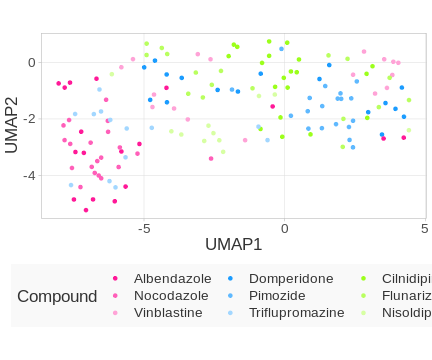

RObject{VecSxp}


In [48]:
gp = ggplot(umTPM, aes(:UMAP1, :UMAP2)) + 
    geom_point(aes(color = :Compound), alpha = 1) +
    coord_fixed() + scale_color_manual(values = moa_palette) + 
    theme(var"legend.position"="bottom", var"legend.spacing.x" = unit(0.35, "cm"), 
    var"legend.spacing.y" = unit(0, "cm")) + 
    guides(color=guide_legend(nrow=3,byrow=false))

In [ ]:
ggsave("Fig/topMOA_UMAP2.pdf", gp)